# Load Library

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/code-heroku-collaborative-recommendation-system/toy_dataset.csv
/kaggle/input/code-heroku-collaborative-recommendation-system/ratings.csv
/kaggle/input/code-heroku-collaborative-recommendation-system/movies.csv


# Data Wrangling

In [2]:
ratings = pd.read_csv('/kaggle/input/code-heroku-collaborative-recommendation-system/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])
movies = pd.read_csv('/kaggle/input/code-heroku-collaborative-recommendation-system/movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [3]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Exploratory Data Analysis(EDA)

<BarContainer object of 19 artists>

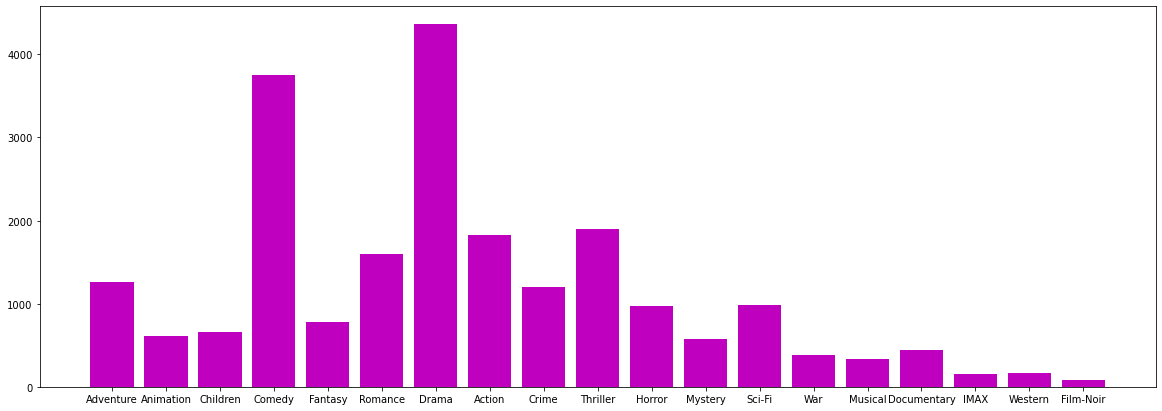

In [4]:
plt.figure(figsize=(20,7))
generlist = movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m')

In [5]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


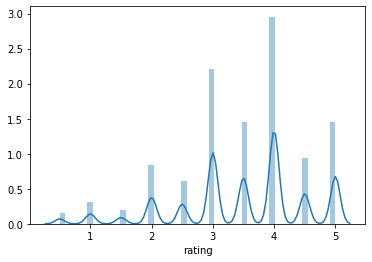

In [6]:
sns.distplot(ratings["rating"]);

# ** Movie Recommendation System With Content Based and Collaborative Filtering Recommender Systems Based Genre**

In [7]:
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')
movies['genres'] = movies['genres'].replace(to_replace="(no genres)", value="")
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies['genres'])
tfidf_movies_genres_matrix.shape

(9742, 22)

In [8]:
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
cosine_sim_movies.shape

(9742, 9742)

In [9]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    idx_movie = movies.loc[movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)
    sim_scores_movies = sim_scores_movies[1:3]
    movie_indices = [i[0] for i in sim_scores_movies]
    return movies['title'].iloc[movie_indices]

In [10]:
get_recommendations_based_on_genres("Jumanji (1995)")

53     Indian in the Cupboard, The (1995)
109     NeverEnding Story III, The (1994)
Name: title, dtype: object

In [11]:
def get_recommendation_content_model(userId):
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = ratings[ratings["userId"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((movies["title"][row["movieId"]==movies["movieId"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(2)

{'39 Steps, The (1935)',
 'Ace Ventura: When Nature Calls (1995)',
 'Amateur (1994)',
 'Apocalypse Now (1979)',
 'Assassins (1995)',
 'Batman Begins (2005)',
 'Ben-Hur (1959)',
 'Boot, Das (Boat, The) (1981)',
 'Catwalk (1996)',
 'City Hall (1996)',
 'Clear and Present Danger (1994)',
 'Cloud Atlas (2012)',
 'Dangerous Minds (1995)',
 'Dead Man Walking (1995)',
 'Deep Impact (1998)',
 'Die Hard: With a Vengeance (1995)',
 'Escape from L.A. (1996)',
 'Four Rooms (1995)',
 'Game, The (1997)',
 'Gattaca (1997)',
 'Hands on a Hard Body (1996)',
 'Heidi Fleiss: Hollywood Madam (1995)',
 'Independence Day (a.k.a. ID4) (1996)',
 'It Came from Hollywood (1982)',
 'Jimmy Hollywood (1994)',
 'Juror, The (1996)',
 'Kiss of Death (1995)',
 'Leaving Las Vegas (1995)',
 'Low Down Dirty Shame, A (1994)',
 'LÃ©on: The Professional (a.k.a. The Professional) (LÃ©on) (1994)',
 'Man in the Iron Mask, The (1998)',
 'Naked Gun 33 1/3: The Final Insult (1994)',
 'Need for Speed (2014)',
 "Once Upon a Time in

# Model evaluation with KNN

In [12]:
def get_movie_label(movie_id):
    classifier = KNeighborsClassifier(n_neighbors=5)
    x = tfidf_movies_genres_matrix
    y = movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [13]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    for key, colums in movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.935998768220078
Fault:0.064001231779922


# Movie Recommendation System With Content Based and Collaborative Filtering Recommender Systems Based On Similarity

Asumsi yang mendasari pendekatan collaborative filtering models adalah bahwa jika A memiliki pendapat yang sama dengan B pada suatu masalah, A lebih mungkin memiliki pendapat yang sama dengan B pada masalah yang berbeda dari pada orang yang dipilih secara acak.
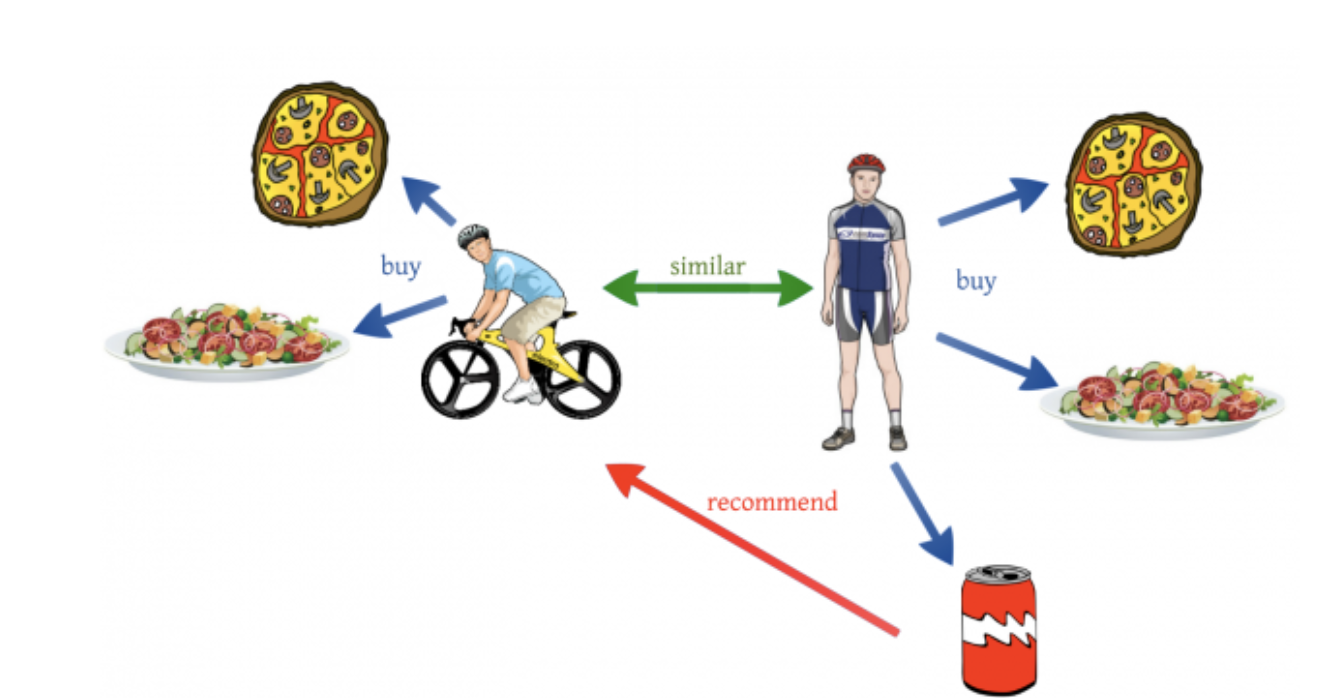

In [14]:
merge = pd.merge(movies, ratings)
merge

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [15]:
ratings_matrix_items = merge.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(9724, 610)

In [16]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.to_numpy(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 )
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [18]:
def item_similarity(movieName): 
    try:
        user_inp=movieName
        inp=movies[movies['title']==user_inp].index.tolist()
        inp=inp[0]

        movies['similarity'] = ratings_matrix_items.iloc[inp]
        movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

In [19]:
def recommendedMoviesAsperItemSimilarity(user_id):
    user_movie= merge[(merge.userId==user_id) & merge.rating.isin([5,4.5])][['title']]
    user_movie=user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice=movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies=list()
    df_recommended_item=pd.DataFrame()
    user2Movies= ratings[ratings['userId']== user_id]['movieId']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new= ratings[(ratings.movieId==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movieId']

In [20]:
def movieIdToTitle(listMovieIDs):
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(movies[movies['movie_id']==id]['title'])
    return movie_titles

In [21]:
user_id = 2
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [4705    Battle Royale (Batoru rowaiaru) (2000)
Name: title, dtype: object, 2103    Big (1988)
Name: title, dtype: object, 2103    Big (1988)
Name: title, dtype: object, 4427    Pirates of the Caribbean: The Curse of the Bla...
Name: title, dtype: object, 4529    Lost in Translation (2003)
Name: title, dtype: object, 2103    Big (1988)
Name: title, dtype: object, 3527    Joy Ride (2001)
Name: title, dtype: object, 1224    Game, The (1997)
Name: title, dtype: object, 1224    Game, The (1997)
Name: title, dtype: object]


In [22]:
ratings_matrix_users = merge.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.to_numpy(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


In [23]:
ratings_matrix_users.idxmax(axis=1)

0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

In [24]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user

,similarUser
0,265
1,365
2,312
3,390
4,469
...,...
605,473
606,569
607,479
608,339


In [25]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    user2Movies= ratings[ratings['userId']== userId]['movieId']
    sim_user=df_similar_user.iloc[0,0]
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    for movieId in ratings[ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= merge[(merge.userId==sim_user) & (merge.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
        best10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movieId']

In [26]:
user_id = 2
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[275    Stargate (1994)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 898    Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object]


**Sumber :**

https://www.datacamp.com/community/tutorials/recommender-systems-python
https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0

